In [1]:
import pandas as pd
from stable_baselines3.common.logger import configure

from finrl.agents.stablebaselines3.models import DRLAgent as StockDRLAgent
from finrl.agents.portfolio_optimization.models import DRLAgent as OptDRLAgent

from finrl.config import TRAINED_MODEL_DIR, RESULTS_DIR
from finrl.main import check_and_make_directories
from finrl.meta.env_stock_trading.env_stocktrading import StockTradingEnv

import numpy as np


TIME_WINDOW = 25
COMMISSION_FEE_PERCENT = 0.001
INITIAL_CASH = 1000000


TRAIN_START_DATE = '2009-04-01'
TRAIN_END_DATE = '2021-12-31'


TEST_TICKER = [
   "MSFT",
    "V",
    "AAPL",
    "BA",
    "INTC",
    "WMT",
]

TRAINED_PPO = "/agent_opt_ppo_update"

GRAPH_TITLE = "PPO Trained 2009-2021, Two Million Time Steps Checkpoint"


# Backtest the results


from finrl.meta.preprocessor.yahoodownloader import YahooDownloader



df = YahooDownloader(start_date = TRAIN_START_DATE,
                     end_date = TRAIN_END_DATE,
                     ticker_list = TEST_TICKER).fetch_data()

processed = df.copy()
processed = processed.fillna(0)
processed_test = processed.replace(np.inf,0)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

Shape of DataFrame:  (19266, 8)


In [2]:
from sklearn.preprocessing import MaxAbsScaler
from finrl.meta.preprocessor.preprocessors import GroupByScaler

portfolio_norm_df = GroupByScaler(by="tic", scaler=MaxAbsScaler).fit_transform(processed_test)
portfolio_norm_df

c:\Users\bencj\Desktop\Econ4\Thesis\.venv\lib\site-packages\finrl\meta\preprocessor\preprocessors.py:101: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[0.31332941 0.43188074 0.33824661 ... 0.0420757  0.03314671 0.03177728]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  X.loc[select_mask, self.columns] = self.scalers[value].transform(
c:\Users\bencj\Desktop\Econ4\Thesis\.venv\lib\site-packages\finrl\meta\preprocessor\preprocessors.py:101: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[0.5  0.75 1.   ... 0.25 0.5  0.75]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  X.loc[select_mask, self.columns] = self.scalers[value].transform(


,date,open,high,low,close,volume,tic,day
0,2009-04-01,0.020525,0.021374,0.020783,0.018456,0.313329,AAPL,0.50
1,2009-04-01,0.077397,0.079819,0.077716,0.062400,0.089997,BA,0.50
2,2009-04-01,0.216569,0.221100,0.217204,0.153140,0.377145,INTC,0.50
3,2009-04-01,0.052899,0.055366,0.053127,0.042764,0.302015,MSFT,0.50
4,2009-04-01,0.054739,0.055408,0.054015,0.049621,0.130785,V,0.50
...,...,...,...,...,...,...,...,...
19261,2021-12-30,0.455147,0.461873,0.460256,0.471090,0.067943,BA,0.75
19262,2021-12-30,0.761290,0.752490,0.767345,0.772947,0.092257,INTC,0.75
19263,2021-12-30,0.992136,0.981297,0.990123,0.988954,0.050090,MSFT,0.75
19264,2021-12-30,0.871706,0.867337,0.874829,0.870964,0.011296,V,0.75


# Portfolio Optimization Algorithm

In [3]:
from finrl.meta.env_portfolio_optimization.env_portfolio_optimization import PortfolioOptimizationEnv


# Fit for the portfolio optimization model

from sklearn.preprocessing import MaxAbsScaler
from finrl.meta.preprocessor.preprocessors import GroupByScaler


environment = PortfolioOptimizationEnv(
    portfolio_norm_df,
    initial_amount=INITIAL_CASH,
    comission_fee_pct=COMMISSION_FEE_PERCENT,
    time_window=TIME_WINDOW,
    features=["close", "high", "low"],
    normalize_df=None
)

In [4]:
import torch
from finrl.agents.portfolio_optimization.architectures import EIIE

device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

# set PolicyGradient parameters
model_kwargs = {
    "lr": 0.01,
    "policy": EIIE,
}

# here, we can set EIIE's parameters
policy_kwargs = {
    "k_size": 3,
    "time_window": TIME_WINDOW,
}


# instantiate an architecture with the same arguments used in training
# and load with load_state_dict.
policy = EIIE(time_window=TIME_WINDOW, device=device)
policy.load_state_dict(torch.load("policy_EIIE.pt"))

C:\Users\bencj\AppData\Local\Temp\ipykernel_20736\3962532677.py:22: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  policy.load_state_dict(torch.load("policy_EIIE.pt"))


<All keys matched successfully>

In [5]:
EIIE_results = {
    "train": {},
}

# 2021 - 2024
# Initialize the model
model = OptDRLAgent(environment).get_model("pg", device, model_kwargs, policy_kwargs)
OptDRLAgent.DRL_validation(model, environment, policy=policy)
EIIE_results["train"]["value"] = environment._asset_memory["final"]
EIIE_results["train"]["date"] = environment._date_memory



# Write this out to a csv file, with date and net worth
df_opt = pd.DataFrame(EIIE_results["train"]["value"], columns=['opt_net_worth'])
df_date = pd.DataFrame(EIIE_results["train"]["date"], columns=['Date'])
if len(df_opt) == len(df_date):
    df_opt['Date'] = df_date['Date']
else:
    raise ValueError("DataFrames do not have the same number of rows.")


# The optimization algoirhtm has a shorter window than the full df, so shorted this for the follow algorithm
opt_start = df_opt.loc[0,'Date']


Initial portfolio value:1000000
Final portfolio value: 13247912.0
Final accumulative portfolio value: 13.247912
Maximum DrawDown: -0.3561143175966025
Sharpe ratio: 1.1514067445327067


In [6]:
print(df_opt)

      opt_net_worth       Date
0      1.000000e+06 2009-05-06
1      9.851882e+05 2009-05-07
2      9.979606e+05 2009-05-08
3      9.899615e+05 2009-05-11
4      9.833551e+05 2009-05-12
...             ...        ...
3182   1.312099e+07 2021-12-23
3183   1.326758e+07 2021-12-27
3184   1.330753e+07 2021-12-28
3185   1.328965e+07 2021-12-29
3186   1.324791e+07 2021-12-30

[3187 rows x 2 columns]


In [7]:
opt_end = df_opt.loc[len(df_date)-1,'Date']

print(opt_start)
opt_start = opt_start.strftime('%Y-%m-%d %H:%M:%S')


print(opt_end)
opt_end = opt_end.strftime('%Y-%m-%d %H:%M:%S')

2009-05-06 00:00:00
2021-12-30 00:00:00


# PPO On portfolio Opt

In [8]:

# Fit for the portfolio optimization model

from sklearn.preprocessing import MaxAbsScaler
from finrl.meta.preprocessor.preprocessors import GroupByScaler

from finrl.meta.preprocessor.preprocessors import data_split

from datetime import datetime, timedelta
# Make sure dates line up, TODO fix this for real dates
# Make sure we only test on the same data as the portfolio optimization algorithm
# Convert to datetime
opt_start_date = datetime.strptime(opt_start, '%Y-%m-%d %H:%M:%S')

print(opt_start_date)

# Subtract one day
new_opt_start_date = opt_start_date - timedelta(days=1)

# Convert back to string
new_opt_start_str = new_opt_start_date.strftime('%Y-%m-%d %H:%M:%S')

train = data_split(portfolio_norm_df, new_opt_start_str,opt_end)

environment_ppo = PortfolioOptimizationEnv(
    train,
    initial_amount=INITIAL_CASH,
    comission_fee_pct=COMMISSION_FEE_PERCENT,
    # time_window=TIME_WINDOW,
    features=["close", "high", "low"],
    normalize_df=None
)

2009-05-06 00:00:00


In [9]:
from stable_baselines3 import PPO
from finrl.config import TRAINED_MODEL_DIR


# Load the trained models
# trained_ppo_opt = PPO.load(TRAINED_MODEL_DIR + "/agent_opt_ppo_10_27") 


trained_ppo_opt = PPO.load(TRAINED_MODEL_DIR + TRAINED_PPO) 

In [10]:
from finrl.agents.portfolio_optimization.models_stable import DRLStableAgent


PPO_results = {
    "train": {},
}

values, dates = DRLStableAgent.DRL_prediction(trained_ppo_opt, environment_ppo)
PPO_results["train"]["value"] = environment_ppo._terminal_asset_memory["final"]
PPO_results["train"]["date"] = environment_ppo._terminal_date_memory


# Write this out to a csv file, with date and net worth
df_ppo_opt = pd.DataFrame(PPO_results["train"]["value"], columns=['ppo_opt_net_worth'])
df_ppo_date = pd.DataFrame(PPO_results["train"]["date"], columns=['Date'])
if len(df_ppo_opt) == len(df_ppo_date):
    df_ppo_opt['Date'] = df_ppo_date['Date']
else:
    raise ValueError("DataFrames do not have the same number of rows.")

print(df_ppo_opt)


print(df_opt.loc[0,'Date'])
print(df_ppo_opt.loc[0, 'Date'])

# assert the dates line up
assert df_opt.loc[0,'Date'] == df_ppo_opt.loc[0, 'Date']
assert df_opt.loc[len(df_date)-1,'Date'] == df_ppo_opt.loc[len(df_ppo_opt)-1,'Date']

c:\Users\bencj\Desktop\Econ4\Thesis\.venv\lib\site-packages\stable_baselines3\common\vec_env\patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


Initial portfolio value:1000000
Final portfolio value: 11696922.0
Final accumulative portfolio value: 11.696922
Maximum DrawDown: -0.3382123776479766
Sharpe ratio: 1.1054905263844939
hit end!
      ppo_opt_net_worth       Date
0          1.000000e+06 2009-05-06
1          9.893685e+05 2009-05-07
2          1.002013e+06 2009-05-08
3          9.995899e+05 2009-05-11
4          9.874551e+05 2009-05-12
...                 ...        ...
3182       1.157728e+07 2021-12-23
3183       1.173372e+07 2021-12-27
3184       1.173552e+07 2021-12-28
3185       1.173094e+07 2021-12-29
3186       1.169692e+07 2021-12-30

[3187 rows x 2 columns]
2009-05-06 00:00:00
2009-05-06 00:00:00


In [11]:
df_ppo_opt.loc[0, 'Date']

Timestamp('2009-05-06 00:00:00')

In [12]:
df_opt.loc[0,'Date']

Timestamp('2009-05-06 00:00:00')

# Porfolio Baselines

In [13]:
# CRP 

CRP_results = {
    "train": {},
}

environment_ppo.reset()
agent_crp = DRLStableAgent(env = environment_ppo)
model_crp = agent_crp.get_model("crp", None, None)

values, dates = DRLStableAgent.DRL_prediction(model_crp, environment_ppo)
CRP_results["train"]["value"] = environment_ppo._terminal_asset_memory["final"]
CRP_results["train"]["date"] = environment_ppo._terminal_date_memory

df_crp_opt = pd.DataFrame(CRP_results["train"]["value"], columns=['crp_opt_net_worth'])
df_crp_date = pd.DataFrame(CRP_results["train"]["date"], columns=['Date'])
if len(df_crp_opt) == len(df_crp_date):
    df_crp_opt['Date'] = df_crp_date['Date']
else:
    raise ValueError("DataFrames do not have the same number of rows.")

print(df_crp_opt)


# assert the dates line up
assert df_opt.loc[0,'Date'] == df_crp_opt.loc[0, 'Date']
assert df_opt.loc[len(df_date)-1,'Date'] == df_crp_opt.loc[len(df_crp_opt)-1,'Date']

c:\Users\bencj\Desktop\Econ4\Thesis\.venv\lib\site-packages\stable_baselines3\common\vec_env\patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


Initial portfolio value:1000000
Final portfolio value: 13249599.0
Final accumulative portfolio value: 13.249599
Maximum DrawDown: -0.3561145894333375
Sharpe ratio: 1.1514499997696843
hit end!
      crp_opt_net_worth       Date
0          1.000000e+06 2009-05-06
1          9.851871e+05 2009-05-07
2          9.979606e+05 2009-05-08
3          9.899609e+05 2009-05-11
4          9.833539e+05 2009-05-12
...                 ...        ...
3182       1.312266e+07 2021-12-23
3183       1.326928e+07 2021-12-27
3184       1.330922e+07 2021-12-28
3185       1.329134e+07 2021-12-29
3186       1.324960e+07 2021-12-30

[3187 rows x 2 columns]


In [14]:
# BAH

BAH_results = {
    "train": {},
}

environment_ppo.reset()
agent_bah = DRLStableAgent(env = environment_ppo)
model_bah = agent_bah.get_model("bah", None, None)

values, dates = DRLStableAgent.DRL_prediction(model_bah, environment_ppo)
BAH_results["train"]["value"] = environment_ppo._terminal_asset_memory["final"]
BAH_results["train"]["date"] = environment_ppo._terminal_date_memory

df_bah_opt = pd.DataFrame(BAH_results["train"]["value"], columns=['bah_opt_net_worth'])
df_bah_date = pd.DataFrame(BAH_results["train"]["date"], columns=['Date'])
if len(df_bah_opt) == len(df_bah_date):
    df_bah_opt['Date'] = df_bah_date['Date']
else:
    raise ValueError("DataFrames do not have the same number of rows.")

print(df_bah_opt)


# assert the dates line up
assert df_opt.loc[0,'Date'] == df_bah_opt.loc[0, 'Date']
assert df_opt.loc[len(df_date)-1,'Date'] == df_bah_opt.loc[len(df_bah_opt)-1,'Date']

c:\Users\bencj\Desktop\Econ4\Thesis\.venv\lib\site-packages\stable_baselines3\common\vec_env\patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


Initial portfolio value:1000000
Final portfolio value: 15905675.0
Final accumulative portfolio value: 15.905675
Maximum DrawDown: -0.35406429469345924
Sharpe ratio: 1.1832579066317002
hit end!
      bah_opt_net_worth       Date
0          1.000000e+06 2009-05-06
1          9.851871e+05 2009-05-07
2          9.980465e+05 2009-05-08
3          9.896784e+05 2009-05-11
4          9.831298e+05 2009-05-12
...                 ...        ...
3182       1.574604e+07 2021-12-23
3183       1.601958e+07 2021-12-27
3184       1.598921e+07 2021-12-28
3185       1.599055e+07 2021-12-29
3186       1.590568e+07 2021-12-30

[3187 rows x 2 columns]


In [15]:
# OLMAR

OLMAR_results = {
    "train": {},
}

OLMAR_model_kwargs = {
    "eps": 60,
    "window": 100
}



environment_ppo.reset()
agent_olmar = DRLStableAgent(env = environment_ppo)
model_olmar = agent_olmar.get_model("olmar", model_kwargs=OLMAR_model_kwargs)

values, dates = DRLStableAgent.DRL_prediction(model_olmar, environment_ppo)
OLMAR_results["train"]["value"] = environment_ppo._terminal_asset_memory["final"]
OLMAR_results["train"]["date"] = environment_ppo._terminal_date_memory

df_olmar_opt = pd.DataFrame(OLMAR_results["train"]["value"], columns=['olmar_opt_net_worth'])
df_olmar_date = pd.DataFrame(OLMAR_results["train"]["date"], columns=['Date'])
if len(df_olmar_opt) == len(df_olmar_date):
    df_olmar_opt['Date'] = df_olmar_date['Date']
else:
    raise ValueError("DataFrames do not have the same number of rows.")

print(df_olmar_opt)


# assert the dates line up
assert df_opt.loc[0,'Date'] == df_olmar_opt.loc[0, 'Date']
assert df_opt.loc[len(df_date)-1,'Date'] == df_olmar_opt.loc[len(df_olmar_opt)-1,'Date']

c:\Users\bencj\Desktop\Econ4\Thesis\.venv\lib\site-packages\stable_baselines3\common\vec_env\patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


Initial portfolio value:1000000
Final portfolio value: 4945205.0
Final accumulative portfolio value: 4.945205
Maximum DrawDown: -0.7357711956972026
Sharpe ratio: 0.5450261640061455
hit end!
      olmar_opt_net_worth       Date
0            1.000000e+06 2009-05-06
1            9.851871e+05 2009-05-07
2            9.884822e+05 2009-05-08
3            9.626134e+05 2009-05-11
4            9.658125e+05 2009-05-12
...                   ...        ...
3182         4.982042e+06 2021-12-23
3183         4.956426e+06 2021-12-27
3184         5.028638e+06 2021-12-28
3185         4.968380e+06 2021-12-29
3186         4.945205e+06 2021-12-30

[3187 rows x 2 columns]


In [16]:
# RMR 

RMR_results = {
    "train": {},
}

RMR_model_kwargs = {
    "eps": 60,
    "window": 100
}

environment_ppo.reset()
agent_rmr = DRLStableAgent(env = environment_ppo)
model_rmr = agent_rmr.get_model("rmr", model_kwargs=RMR_model_kwargs)

values, dates = DRLStableAgent.DRL_prediction(model_rmr, environment_ppo)
RMR_results["train"]["value"] = environment_ppo._terminal_asset_memory["final"]
RMR_results["train"]["date"] = environment_ppo._terminal_date_memory

df_rmr_opt = pd.DataFrame(RMR_results["train"]["value"], columns=['rmr_opt_net_worth'])
df_rmr_date = pd.DataFrame(RMR_results["train"]["date"], columns=['Date'])
if len(df_rmr_opt) == len(df_rmr_date):
    df_rmr_opt['Date'] = df_rmr_date['Date']
else:
    raise ValueError("DataFrames do not have the same number of rows.")

print(df_rmr_opt)


# assert the dates line up
assert df_opt.loc[0,'Date'] == df_rmr_opt.loc[0, 'Date']
assert df_opt.loc[len(df_date)-1,'Date'] == df_rmr_opt.loc[len(df_rmr_opt)-1,'Date']

c:\Users\bencj\Desktop\Econ4\Thesis\.venv\lib\site-packages\stable_baselines3\common\vec_env\patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


Initial portfolio value:1000000
Final portfolio value: 33407580.0
Final accumulative portfolio value: 33.40758
Maximum DrawDown: -0.4379711556709409
Sharpe ratio: 1.1305042703499708
hit end!
      rmr_opt_net_worth       Date
0          1.000000e+06 2009-05-06
1          9.851871e+05 2009-05-07
2          9.884822e+05 2009-05-08
3          9.626134e+05 2009-05-11
4          9.658125e+05 2009-05-12
...                 ...        ...
3182       3.304763e+07 2021-12-23
3183       3.380690e+07 2021-12-27
3184       3.361192e+07 2021-12-28
3185       3.362880e+07 2021-12-29
3186       3.340758e+07 2021-12-30

[3187 rows x 2 columns]


In [17]:
# BNN

BNN_results = {
    "train": {},
}

# RMR_model_kwargs = {
#     "eps": 60,
#     "window": 100
# }

environment_ppo.reset()
agent_bnn = DRLStableAgent(env = environment_ppo)
model_bnn = agent_bnn.get_model("bnn", model_kwargs=None)

values, dates = DRLStableAgent.DRL_prediction(model_bnn, environment_ppo)
BNN_results["train"]["value"] = environment_ppo._terminal_asset_memory["final"]
BNN_results["train"]["date"] = environment_ppo._terminal_date_memory

df_bnn_opt = pd.DataFrame(BNN_results["train"]["value"], columns=['bnn_opt_net_worth'])
df_bnn_date = pd.DataFrame(BNN_results["train"]["date"], columns=['Date'])
if len(df_bnn_opt) == len(df_bnn_date):
    df_bnn_opt['Date'] = df_bnn_date['Date']
else:
    raise ValueError("DataFrames do not have the same number of rows.")

print(df_bnn_opt)


# assert the dates line up
assert df_opt.loc[0,'Date'] == df_bnn_opt.loc[0, 'Date']
assert df_opt.loc[len(df_date)-1,'Date'] == df_bnn_opt.loc[len(df_bnn_opt)-1,'Date']

c:\Users\bencj\Desktop\Econ4\Thesis\.venv\lib\site-packages\stable_baselines3\common\vec_env\patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


Initial portfolio value:1000000
Final portfolio value: 28380684.0
Final accumulative portfolio value: 28.380684
Maximum DrawDown: -0.4379715234929442
Sharpe ratio: 1.0860175232032556
hit end!
      bnn_opt_net_worth       Date
0             1000000.0 2009-05-06
1             1000000.0 2009-05-07
2             1000000.0 2009-05-08
3             1000000.0 2009-05-11
4             1000000.0 2009-05-12
...                 ...        ...
3182         28074902.0 2021-12-23
3183         28719918.0 2021-12-27
3184         28554276.0 2021-12-28
3185         28568620.0 2021-12-29
3186         28380684.0 2021-12-30

[3187 rows x 2 columns]


In [18]:
# SCRP


SCRP_results = {
    "train": {},
}


# now make the predictions with the historical price data, but in the test period only
SCRP_model_kwargs = {
    "price_history": None
}

environment_ppo.reset()
agent_scrp = DRLStableAgent(env = environment_ppo)
model_scrp = agent_scrp.get_model("scrp", model_kwargs=SCRP_model_kwargs)

values, dates = DRLStableAgent.DRL_prediction(model_scrp, environment_ppo)
SCRP_results["train"]["value"] = environment_ppo._terminal_asset_memory["final"]
SCRP_results["train"]["date"] = environment_ppo._terminal_date_memory

df_scrp_opt = pd.DataFrame(SCRP_results["train"]["value"], columns=['scrp_opt_net_worth'])
df_scrp_date = pd.DataFrame(SCRP_results["train"]["date"], columns=['Date'])
if len(df_scrp_opt) == len(df_scrp_date):
    df_scrp_opt['Date'] = df_scrp_date['Date']
else:
    raise ValueError("DataFrames do not have the same number of rows.")

print(df_scrp_opt)


# assert the dates line up
assert df_opt.loc[0,'Date'] == df_scrp_opt.loc[0, 'Date']
assert df_opt.loc[len(df_date)-1,'Date'] == df_scrp_opt.loc[len(df_scrp_opt)-1,'Date']

c:\Users\bencj\Desktop\Econ4\Thesis\.venv\lib\site-packages\stable_baselines3\common\vec_env\patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


Initial portfolio value:1000000
Final portfolio value: 34866760.0
Final accumulative portfolio value: 34.86676
Maximum DrawDown: -0.43797116201173525
Sharpe ratio: 1.1502747421683226
hit end!
      scrp_opt_net_worth       Date
0           1.000000e+06 2009-05-06
1           9.851871e+05 2009-05-07
2           9.884822e+05 2009-05-08
3           9.504656e+05 2009-05-11
4           9.536242e+05 2009-05-12
...                  ...        ...
3182        3.449109e+07 2021-12-23
3183        3.528352e+07 2021-12-27
3184        3.508002e+07 2021-12-28
3185        3.509764e+07 2021-12-29
3186        3.486676e+07 2021-12-30

[3187 rows x 2 columns]


# Try BCRP extreme, which is the absolute best portfolio over the period with hindsight


In [19]:
# bcrp

BCRP_results = {
    "train": {},
}

environment_ppo.reset()
agent_bcrp= DRLStableAgent(env = environment_ppo)
model_bcrp= agent_bcrp.get_model("bcrp", None, None)

values, dates = DRLStableAgent.DRL_prediction(model_bcrp, environment_ppo)
BCRP_results["train"]["value"] = environment_ppo._terminal_asset_memory["final"]
BCRP_results["train"]["date"] = environment_ppo._terminal_date_memory

df_bcrp_opt = pd.DataFrame(BCRP_results["train"]["value"], columns=['bcrp_opt_net_worth'])
df_bcrp_date = pd.DataFrame(BCRP_results["train"]["date"], columns=['Date'])
if len(df_bcrp_opt) == len(df_bcrp_date):
    df_bcrp_opt['Date'] = df_bcrp_date['Date']
else:
    raise ValueError("DataFrames do not have the same number of rows.")

print(df_bcrp_opt)


# assert the dates line up
assert df_opt.loc[0,'Date'] == df_bcrp_opt.loc[0, 'Date']
assert df_opt.loc[len(df_date)-1,'Date'] == df_bcrp_opt.loc[len(df_bcrp_opt)-1,'Date']

c:\Users\bencj\Desktop\Econ4\Thesis\.venv\lib\site-packages\stable_baselines3\common\vec_env\patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


Initial portfolio value:1000000
Final portfolio value: 43922076.0
Final accumulative portfolio value: 43.922076
Maximum DrawDown: -0.4379716266264583
Sharpe ratio: 1.208725175631226
hit end!
      bcrp_opt_net_worth       Date
0           1.000000e+06 2009-05-06
1           9.740378e+05 2009-05-07
2           9.750191e+05 2009-05-08
3           9.778869e+05 2009-05-11
4           9.390190e+05 2009-05-12
...                  ...        ...
3182        4.344884e+07 2021-12-23
3183        4.444707e+07 2021-12-27
3184        4.419072e+07 2021-12-28
3185        4.421292e+07 2021-12-29
3186        4.392208e+07 2021-12-30

[3187 rows x 2 columns]


# Stock environment optimization algorithm

In [20]:
from finrl.meta.preprocessor.preprocessors import data_split

# Make sure we only test on the same data as the portfolio optimization algorithm
# test = data_split(test, opt_start,opt_end)


In [21]:
# Pull the DJI results

from finrl.plot import backtest_stats, backtest_plot, get_daily_return, get_baseline


df_dji_ = get_baseline(
        ticker="^DJI",
        start = df_date.loc[0,'Date'],
        end = df_date.loc[len(df_date)-1,'Date'])

stats = backtest_stats(df_dji_, value_col_name = 'close')

df_dji = pd.DataFrame()
df_dji['date'] = df_date['Date']
df_dji['dji'] = df_dji_['close'] / df_dji_['close'][0] * INITIAL_CASH
print("df_dji: ", df_dji)
df_dji.to_csv("df_dji.csv")
df_dji = df_dji.set_index(df_dji.columns[0])
print("df_dji: ", df_dji)


c:\Users\bencj\Desktop\Econ4\Thesis\.venv\lib\site-packages\pyfolio\pos.py:26: UserWarning: Module "zipline.assets" not found; mutltipliers will not be applied to position notionals.
  warnings.warn(
[*********************100%***********************]  1 of 1 completed

Shape of DataFrame:  (3186, 8)
Annual return          0.122012
Cumulative returns     3.286587
Annual volatility      0.170256
Sharpe ratio           0.762055
Calmar ratio           0.328996
Stability              0.971208
Max drawdown          -0.370862
Omega ratio            1.161853
Sortino ratio          1.065189
Skew                        NaN
Kurtosis                    NaN
Tail ratio             0.947005
Daily value at risk   -0.020935
dtype: float64
df_dji:             date           dji
0    2009-05-06  1.000000e+06
1    2009-05-07  9.879667e+05
2    2009-05-08  1.007327e+06
3    2009-05-11  9.890146e+05
4    2009-05-12  9.949285e+05
...         ...           ...
3182 2021-12-23  4.223376e+06
3183 2021-12-27  4.264707e+06
3184 2021-12-28  4.275965e+06
3185 2021-12-29  4.286587e+06
3186 2021-12-30           NaN

[3187 rows x 2 columns]
df_dji:                       dji
date                    
2009-05-06  1.000000e+06
2009-05-07  9.879667e+05
2009-05-08  1.007327e+06
2009-05-11

# Compare all results

In [22]:
# Join the online algorithms

# bcrp = pd.read_csv('BCRP_net_worth.csv')
# crp = pd.read_csv('CRP_net_worth.csv')
# olmar = pd.read_csv('OLMAR_net_worth.csv')



# merged_df = olmar
# merged_df = pd.merge(merged_df, olmar, on='Date')

# Merge the baseline CRP algorithm
df_crp_opt['Date'] = pd.to_datetime(df_crp_opt['Date'])
merged_df = df_crp_opt

# Merge the baseline BCRP algorithm
df_bcrp_opt['Date'] = pd.to_datetime(df_bcrp_opt['Date'])
merged_df = pd.merge(merged_df, df_bcrp_opt, on='Date')

# Merge the baseline BAH algorithm
df_bah_opt['Date'] = pd.to_datetime(df_bah_opt['Date'])
merged_df = pd.merge(merged_df, df_bah_opt, on='Date')

# Merge the baseline OLMAR algorithm
df_olmar_opt['Date'] = pd.to_datetime(df_olmar_opt['Date'])
merged_df = pd.merge(merged_df, df_olmar_opt, on='Date')

# Merge the baseline RMR algorithm
df_rmr_opt['Date'] = pd.to_datetime(df_rmr_opt['Date'])
merged_df = pd.merge(merged_df, df_rmr_opt, on='Date')

# Merge the baseline BNN algorithm
df_bnn_opt['Date'] = pd.to_datetime(df_bnn_opt['Date'])
merged_df = pd.merge(merged_df, df_bnn_opt, on='Date')

# Merge the baseline SCRP algorithm
df_scrp_opt['Date'] = pd.to_datetime(df_scrp_opt['Date'])
merged_df = pd.merge(merged_df, df_scrp_opt, on='Date')

# Merge the opt algorithm
df_opt['Date'] = pd.to_datetime(df_opt['Date'])
merged_df = pd.merge(merged_df, df_opt, on='Date')

# Merge the PPO opt algorithm
df_ppo_opt['Date'] = pd.to_datetime(df_ppo_opt['Date'])
merged_df = pd.merge(merged_df, df_ppo_opt, on='Date')


print(df_dji)
df_dji = df_dji.reset_index()
df_dji.rename(columns={'date': 'Date'}, inplace=True)
merged_df = pd.merge(merged_df, df_dji, on='Date')


print(merged_df)


                     dji
date                    
2009-05-06  1.000000e+06
2009-05-07  9.879667e+05
2009-05-08  1.007327e+06
2009-05-11  9.890146e+05
2009-05-12  9.949285e+05
...                  ...
2021-12-23  4.223376e+06
2021-12-27  4.264707e+06
2021-12-28  4.275965e+06
2021-12-29  4.286587e+06
2021-12-30           NaN

[3187 rows x 1 columns]
      crp_opt_net_worth       Date  bcrp_opt_net_worth  bah_opt_net_worth  \
0          1.000000e+06 2009-05-06        1.000000e+06       1.000000e+06   
1          9.851871e+05 2009-05-07        9.740378e+05       9.851871e+05   
2          9.979606e+05 2009-05-08        9.750191e+05       9.980465e+05   
3          9.899609e+05 2009-05-11        9.778869e+05       9.896784e+05   
4          9.833539e+05 2009-05-12        9.390190e+05       9.831298e+05   
...                 ...        ...                 ...                ...   
3182       1.312266e+07 2021-12-23        4.344884e+07       1.574604e+07   
3183       1.326928e+07 2021-12-27

# Baseline CRP in the environment

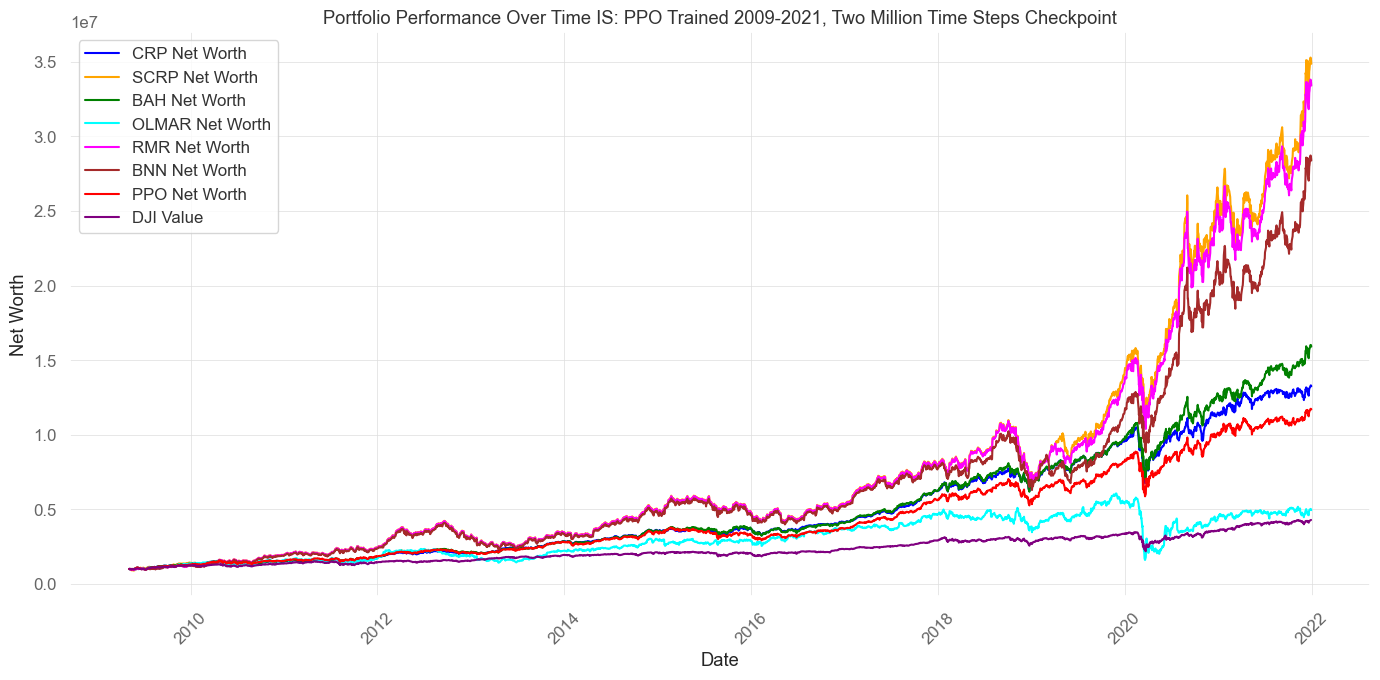

In [23]:
# Use the correct backend for Jupyter
%matplotlib inline
import matplotlib.pyplot as plt

color_map = {
    'CRP Net Worth': 'blue',
    'BAH Net Worth': 'green',
    'PPO Net Worth': 'red',
    'DJI Value': 'purple',
    'SCRP Net Worth': 'orange',
    'OLMAR Net Worth': 'cyan',
    'RMR Net Worth': 'magenta',
    'BNN Net Worth': 'brown'
}

plt.figure(figsize=(14, 7))
plt.plot(merged_df['Date'], merged_df['crp_opt_net_worth'], label='CRP Net Worth', color=color_map['CRP Net Worth'])
plt.plot(merged_df['Date'], merged_df['scrp_opt_net_worth'], label='SCRP Net Worth', color=color_map['SCRP Net Worth'])
plt.plot(merged_df['Date'], merged_df['bah_opt_net_worth'], label='BAH Net Worth', color=color_map['BAH Net Worth'])
plt.plot(merged_df['Date'], merged_df['olmar_opt_net_worth'], label='OLMAR Net Worth', color=color_map['OLMAR Net Worth'])
plt.plot(merged_df['Date'], merged_df['rmr_opt_net_worth'], label='RMR Net Worth', color=color_map['RMR Net Worth'])
plt.plot(merged_df['Date'], merged_df['bnn_opt_net_worth'], label='BNN Net Worth', color=color_map['BNN Net Worth'])
plt.plot(merged_df['Date'], merged_df['ppo_opt_net_worth'], label='PPO Net Worth', color=color_map['PPO Net Worth'])
plt.plot(merged_df['Date'], merged_df['dji'], label='DJI Value', color=color_map['DJI Value'])
plt.xlabel('Date')
plt.ylabel('Net Worth')
plt.title('Portfolio Performance Over Time IS: ' + GRAPH_TITLE)
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

In [24]:
# Final returns

import pprint

final_returns = {
   'BCRP': merged_df['bcrp_opt_net_worth'].iloc[-1],
   'CRP': merged_df['crp_opt_net_worth'].iloc[-1],
   'SCRP': merged_df['scrp_opt_net_worth'].iloc[-1],
   'BAH': merged_df['bah_opt_net_worth'].iloc[-1],
   'OLMAR': merged_df['olmar_opt_net_worth'].iloc[-1],
   'RMR': merged_df['rmr_opt_net_worth'].iloc[-1],
   'BNN': merged_df['bnn_opt_net_worth'].iloc[-1],
   'PPO': merged_df['ppo_opt_net_worth'].iloc[-1]
}

pprint.pprint(final_returns)

{'BAH': 15905675.0,
 'BCRP': 43922076.0,
 'BNN': 28380684.0,
 'CRP': 13249599.0,
 'OLMAR': 4945205.0,
 'PPO': 11696922.0,
 'RMR': 33407580.0,
 'SCRP': 34866760.0}


In [25]:
import numpy as np

# Calculate the returns each day

# merged_df['BCRP_daily_return'] = merged_df['BCRP_net_worth'].pct_change()
# merged_df['CRP_daily_return'] = merged_df['CRP_net_worth'].pct_change()
merged_df['BCRP_opt_daily_return'] = merged_df['bcrp_opt_net_worth'].pct_change()
merged_df['CRP_opt_daily_return'] = merged_df['crp_opt_net_worth'].pct_change()
merged_df['SCRP_opt_daily_return'] = merged_df['scrp_opt_net_worth'].pct_change()

merged_df['BAH_opt_daily_return'] = merged_df['bah_opt_net_worth'].pct_change()
merged_df['OLMAR_opt_daily_return'] = merged_df['olmar_opt_net_worth'].pct_change()
merged_df['RMR_opt_daily_return'] = merged_df['rmr_opt_net_worth'].pct_change()
merged_df['BNN_opt_daily_return'] = merged_df['bnn_opt_net_worth'].pct_change()

merged_df['opt_daily_return'] = merged_df['opt_net_worth'].pct_change()
merged_df['ppo_opt_daily_return'] = merged_df['ppo_opt_net_worth'].pct_change()
# merged_df['ppo_daily_return'] = merged_df['ppo_value'].pct_change()
# merged_df['td3_daily_return'] = merged_df['td3_value'].pct_change()

# TODO need to put in the fama french

# Define the risk-free rate (annual, for example, 2%)
risk_free_rate = 0.02 / 252  # Convert annual risk-free rate to daily

# Define a function to calculate Sharpe ratio adjusted for the risk-free rate
def calculate_sharpe_ratio(returns, risk_free_rate):
    excess_return = returns - risk_free_rate
    mean_excess_return = excess_return.mean()
    std_excess_return = excess_return.std()
    annual_factor = np.sqrt(252)  # Assuming 252 trading days in a year
    sharpe_ratio = annual_factor * mean_excess_return / std_excess_return
    return sharpe_ratio

# Calculate the Sharpe ratio for each daily return column
sharpe_ratios = {
    # 'BCRP': calculate_sharpe_ratio(merged_df['BCRP_daily_return'], risk_free_rate),
    # 'CRP': calculate_sharpe_ratio(merged_df['CRP_daily_return'], risk_free_rate),
    'BCRP': calculate_sharpe_ratio(merged_df['BCRP_opt_daily_return'], risk_free_rate),
    'CRP': calculate_sharpe_ratio(merged_df['CRP_opt_daily_return'], risk_free_rate),
    'SCRP': calculate_sharpe_ratio(merged_df['SCRP_opt_daily_return'], risk_free_rate),
    'BAH': calculate_sharpe_ratio(merged_df['BAH_opt_daily_return'], risk_free_rate),
    'OLMAR': calculate_sharpe_ratio(merged_df['OLMAR_opt_daily_return'], risk_free_rate),
    'RMR': calculate_sharpe_ratio(merged_df['RMR_opt_daily_return'], risk_free_rate),
    'BNN': calculate_sharpe_ratio(merged_df['BNN_opt_daily_return'], risk_free_rate),
    # 'Opt': calculate_sharpe_ratio(merged_df['opt_daily_return'], risk_free_rate),
    'PPO': calculate_sharpe_ratio(merged_df['ppo_opt_daily_return'], risk_free_rate),
    # 'PPO': calculate_sharpe_ratio(merged_df['ppo_daily_return'], risk_free_rate),
    # 'TD3': calculate_sharpe_ratio(merged_df['td3_daily_return'], risk_free_rate)
}

pprint.pprint(sharpe_ratios)

{'BAH': 1.084604966328881,
 'BCRP': 1.1375090232890086,
 'BNN': 1.0147272709409028,
 'CRP': 1.048503889438394,
 'OLMAR': 0.4857193054088873,
 'PPO': 1.0019744380033577,
 'RMR': 1.0593555150965828,
 'SCRP': 1.0784920711764014}


In [26]:
import pandas as pd
import numpy as np

# Assuming merged_df is your DataFrame
# Calculate the max drawdown for each specified column
def max_drawdown(series):
    cumulative_returns = series.cummax()
    drawdowns = series / cumulative_returns - 1
    max_drawdown_value = drawdowns.min()
    return max_drawdown_value

max_drawdowns = {
    # 'BCRP': max_drawdown(merged_df['BCRP_net_worth']),
    # 'CRP': max_drawdown(merged_df['CRP_net_worth']),
    'BCRP': max_drawdown(merged_df['bcrp_opt_net_worth']),
    'CRP': max_drawdown(merged_df['crp_opt_net_worth']),
    'SCRP': max_drawdown(merged_df['scrp_opt_net_worth']),
    'BAH': max_drawdown(merged_df['bah_opt_net_worth']),
    'OLMAR': max_drawdown(merged_df['olmar_opt_net_worth']),
    'RMR': max_drawdown(merged_df['rmr_opt_net_worth']),
    'BNN': max_drawdown(merged_df['bnn_opt_net_worth']),
    # 'Opt': max_drawdown(merged_df['opt_net_worth']),
    'PPO': max_drawdown(merged_df['ppo_opt_net_worth']),
    # 'PPO': max_drawdown(merged_df['ppo_value']),
    # 'TD3': max_drawdown(merged_df['td3_value'])
}

pprint.pprint(max_drawdowns)


{'BAH': -0.35406429469345924,
 'BCRP': -0.4379716266264583,
 'BNN': -0.4379715234929442,
 'CRP': -0.3561145894333375,
 'OLMAR': -0.7357711956972026,
 'PPO': -0.3382123776479766,
 'RMR': -0.4379711556709409,
 'SCRP': -0.43797116201173525}


In [27]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.formula.api import ols


# TODO can we do a statisitical significance test with anova here?
ANOVA_cols = ['ppo_opt_daily_return', 'CRP_opt_daily_return', 'BCRP_opt_daily_return', 'BAH_opt_daily_return']
cols = ['Date',] + ANOVA_cols


df_selected = merged_df[cols]

# Assuming merged_df is your DataFrame and daily returns have already been calculated
# Combine all return columns into one DataFrame for ANOVA
returns_long = df_selected.melt(
    id_vars=['Date'], 
    value_vars=ANOVA_cols,
    var_name='Portfolio', 
    value_name='Daily_Return'
)

# Remove any NaN values created by pct_change()
returns_long.dropna(inplace=True)

# Perform ANOVA
model = ols('Daily_Return ~ Portfolio', data=returns_long).fit()
anova_result = sm.stats.anova_lm(model, typ=2)

# Display the summary of the ANOVA
pprint.pprint(anova_result)

# The results do seem to be statisitcally significant


             sum_sq       df        F    PR(>F)
Portfolio  0.000500      3.0  0.86519  0.458295
Residual   2.454552  12740.0      NaN       NaN
